# Uplift Analysis & A/B Testing

## 1- Introduction - Uplift Analysis & Campaign Effectiveness

This notebook evaluates the impact of a marketing campaign using A/B testing and uplift modeling techniques. We'll quantify how much the campaign changed customer behavior and identify which customer segments responded positively.












We'll answer questions such as:
- Did the campaign increase customer response rates?
- Which groups benefitted most from the campaign?
- Can we model uplift at the customer level?


💡 **What is Uplift?**

Uplift is the difference in behavior (like conversion or response) between people who received a treatment (e.g., a marketing campaign) and those who didn’t (control group). It tells you the incremental effect of the campaign — the true added value.

 💡 **In simple terms:**

$$ \text{Uplift} = \text{Response Rate (Treatment)} − \text{Response Rate (Control)} $$ $$ =  \text{P(Response | Treatment=1)} −  \text{P(Response | Treatment=0)}$$

It measures how much more likely someone is to take the desired action because of the campaign.

💡 **What Is Uplift Modeling?**

Uplift modeling is a technique used to predict the incremental impact of a treatment (like a marketing campaign) on an individual’s behavior — compared to if they hadn’t received the treatment.


💡**Key Idea:**

Instead of predicting **whether** a person will respond, **uplift models** predict **how much more likely** a person is to respond **because of** the treatment.


💡 **Why Not Just Use a Classifier?**
* A traditional classifier predicts:

      “Who is likely to respond?”

* But uplift modeling asks:

      “Who is likely to respond because of the campaign?”

This allows marketers to:

* Avoid targeting customers who would buy anyway.

* Avoid annoying customers who would have churned due to the ad.

* Focus spend on the persuadable ones.

 ## 2- Load Data

In [ ]:
# !pip install xgboost lightgbm

In [22]:
 #!pip install causalml

In [ ]:
# 2. Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from causalml.inference.tree import UpliftTreeClassifier
from causalml.metrics import plot_gain
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [ ]:
# 3. Load Cleaned Data

import pandas as pd

# Load the dataset
df = pd.read_csv('data/campaign_data_cleaned.csv')

# Preview
df.head()

,customer_id,age,gender,income,region,tenure_years,received_campaign,spend_last_month,channel,product_category,responded,spend_this_month,is_high_value,days_since_last_purchase,credit_score,customer_segment
0,CUST00001,56,Female,111974,North,4.5,0,616.04,Email,Loans,1,771.72,0,156,664,1
1,CUST00002,69,Male,42291,South,5.7,0,171.21,Email,Loans,0,171.21,0,185,732,2
2,CUST00003,46,Female,70585,North,5.7,0,280.33,SMS,Loans,0,280.33,0,41,715,0
3,CUST00004,32,Male,78626,East,9.3,0,143.79,SMS,Loans,0,143.79,0,201,725,0
4,CUST00005,60,Female,64871,South,0.0,1,67.43,Email,Loans,1,221.13,0,50,719,3


## 3. Exploratory Check: Campaign vs. Control

Analyzing how many people responded to the marketing campaign, depending on whether they received the campaign or not.

Data in column **['received_campaign']** are splitted into two groups:

*   **0: Control group** (did not receive campaign)
*   **1: Treatment group** (did receive campaign)









In [ ]:
df.groupby('received_campaign')['responded'].value_counts()


received_campaign  responded
0                  0            2433
                   1             123
1                  0            2043
                   1             401
Name: count, dtype: int64

In [ ]:
# 4. Basic A/B Testing – Response Rate

ab_summary = df.groupby("received_campaign")["responded"].agg(['count', 'sum', 'mean']).rename(columns={'mean': 'mean =response_rate'})
ab_summary.index = ['Control (0)', 'Treatment (1)']
ab_summary

,count,sum,mean =response_rate
Control (0),2556,123,0.048122
Treatment (1),2444,401,0.164075


**Column meanings:**

* **Count:** Number of customers in each group.

* **Sum:** Number of customers who responded (responded = 1) in that group.

* **Mean (Response Rate):** The proportion of responders in each group, calculated as sum / count.

**Interpretation:**



*   Control Group (0):

    *   These customers **did not receive** the campaign.
    *   Only ~4.8% of them responded, likely due to natural engagement or randomness.


*  Treatment Group (1):

    *   These customers **did receive** the campaign.
    *   ~16.4% responded, which is much higher than the control group.

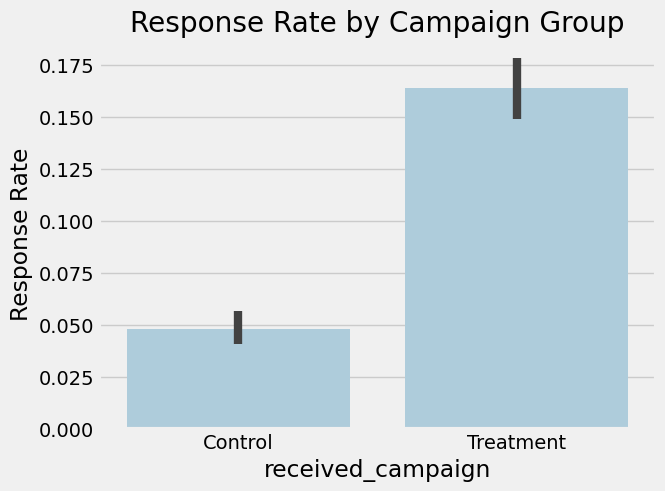

In [ ]:
# Visualize response rates

sns.barplot(x=df['received_campaign'], y=df['responded'])
plt.title("Response Rate by Campaign Group")
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.ylabel("Response Rate")
plt.show()

That Chi-squared test p-value of 1.45e-40 is extremely small; $ p - {value} < 0.05 $, which means:

✅ **Interpretation:**


* Null Hypothesis (H₀): There is no association between receiving the campaign and responding.

* Alternative Hypothesis (H₁): There is an association between receiving the campaign and responding.

🔍 Conclusion:
Since the *p-value* is much smaller than any reasonable alpha level (e.g., 0.05, 0.01, or even 0.0001):



✅ Reject the null hypothesis.

**This means the difference in response rates is not due to random chance — the campaign likely had a real effect on customer behavior.**



In [ ]:
# 5. Calculate Uplift (Simple Difference in Means)

treatment_rate = df[df['received_campaign'] == 1]['responded'].mean()
control_rate = df[df['received_campaign'] == 0]['responded'].mean()
uplift = treatment_rate - control_rate

print(f"Control Response Rate: {control_rate:.4f}")
print(f"Treatment Response Rate: {treatment_rate:.4f}")
print(f"Estimated (Overall) Uplift: {uplift:.4f}")

Control Response Rate: 0.0481
Treatment Response Rate: 0.1641
Estimated (Overall) Uplift: 0.1160


**This means the campaign increased the response rate by 11.6 percentage points.**

The difference between the two response rates (~16.4% - 4.8% = 11.6%) is the uplift — the estimated causal effect of the campaign on customer response.

# Calculating p-value

Just comparing response rates is not enough. To determine whether the difference between treatment and control is statistically significant and not due to random chance, we should calculate a p-value.


A p-value helps you answer:

"Assuming there is no real effect, what is the probability of seeing a difference this large (or larger) just by chance?"


* **Null Hypothesis (H₀):** There is no association between receiving the campaign and responding.

* **Alternative Hypothesis (H₁):** There is an association between receiving the campaign and responding.



If the p-value is small (typically < 0.05), you can reject the null hypothesis (that the campaign had no effect) and say the campaign likely caused the increase in response.




In [ ]:
# Calculate p-value

from scipy.stats import chi2_contingency

# Create a contingency table
# Rows = treatment group (0 = control, 1 = treatment)
# Columns = response (0 = no, 1 = yes)
contingency_table = pd.crosstab(df['received_campaign'], df['responded'])

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared test p-value:", p)

Chi-squared test p-value: 1.4523540718690788e-40


# Uplift Tree Model Evaluation - causalml Library

   treatment  outcome  uplift_score
0          0        1     -0.027778
1          0        0      0.010606
2          0        0      0.188525
3          0        0      0.100000
4          1        1      0.188525


<Figure size 100x100 with 0 Axes>

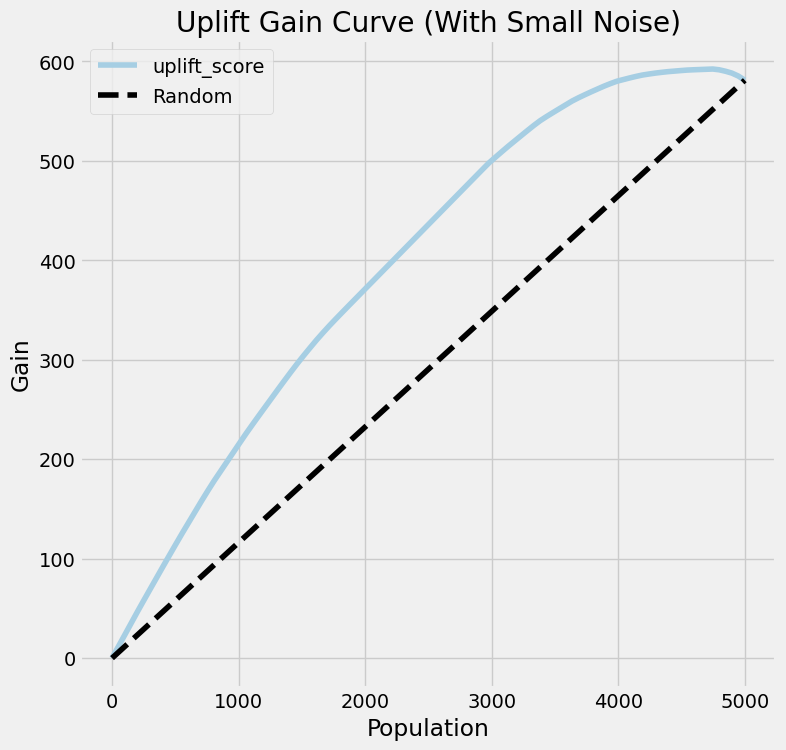

In [ ]:
features = ['age', 'income', 'tenure_years', 'credit_score', 'is_high_value', 'spend_last_month']

# Customer features
X = df[features]

# Whether they received the campaign
treatment = df['received_campaign']

# Whether they responded
y = df['responded']



"""# A - Uplift Tree Model - causalml Library"""

from causalml.inference.tree import UpliftTreeClassifier

# Convert your treatment column to string labels

df['treatment_str'] = df['received_campaign'].map({0: 'control', 1: 'treatment'})
df['treatment_str']



uplift_model = UpliftTreeClassifier(
    control_name='control',
    max_depth=10,
    min_samples_leaf=50,
    min_samples_treatment=30,
    n_reg=10
)


uplift_model.fit(X=X.values, treatment=df['treatment_str'].values, y=y.values)

# Predict uplift scores - this returns a 2D array with shape (n_samples, 2)
uplift_preds = uplift_model.predict(X.values)

# Calculate uplift = P(response | treatment) - P(response | control)
uplift_scores = uplift_preds[:, 1] - uplift_preds[:, 0]

# Save to the DataFrame
df['uplift_score'] = uplift_scores

# Now this will work fine
df['uplift_score']
df.head()

#  Plot Uplift Gain Curve

from causalml.metrics import plot_gain
import matplotlib.pyplot as plt

# Ensure the DataFrame is correctly created
df_uplift_eval = pd.DataFrame({
    'treatment': df['received_campaign'],
    'outcome': df['responded'],                      # 0 or 1
    'uplift_score': uplift_scores      # predicted uplift score (1D array)
})


print(df_uplift_eval.head())


# To break ties in uplift scores:
df_uplift_eval['uplift_score_noisy'] = df_uplift_eval['uplift_score'] + np.random.normal(0, 1e-5, size=len(df_uplift_eval))


plt.figure(figsize=(1, 1))
plot_gain(
    df_uplift_eval,
    outcome_col='outcome',
    treatment_col='treatment',
    treatment_effect_col='uplift_score_noisy'
)

plt.title("Uplift Gain Curve (With Small Noise)")
plt.show()


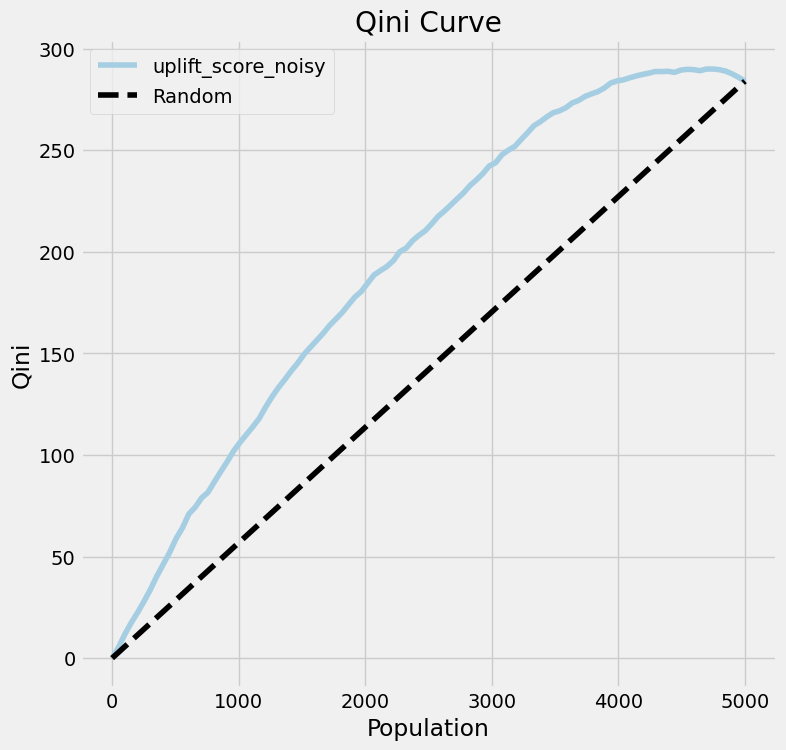

In [ ]:
from causalml.metrics import plot_qini

plot_qini(
    df_uplift_eval,
    outcome_col='outcome',
    treatment_col='treatment',
    treatment_effect_col='uplift_score'
)
plt.title("Qini Curve")
plt.show()

In [ ]:
# Top Target Group

# Target top 10% with highest uplift score
top_10 = df.sort_values("uplift_score", ascending=False).head(int(0.1 * len(df)))
#top_10.describe()
top_10.head()

,customer_id,age,gender,income,region,tenure_years,received_campaign,spend_last_month,channel,product_category,responded,spend_this_month,is_high_value,days_since_last_purchase,credit_score,customer_segment,treatment_str,uplift_score
1092,CUST01093,50,Male,78016,North,6.0,1,202.63,Phone,Loans,1,279.00,0,93,701,0,treatment,0.232588
3272,CUST03273,24,Male,73743,South,1.5,1,195.98,Phone,Insurance,0,195.98,0,245,712,0,treatment,0.232588
3305,CUST03306,60,Female,90201,West,3.5,1,694.52,App Notification,Loans,0,694.52,0,266,710,1,treatment,0.232588
29,CUST00030,42,Male,71658,North,0.6,0,451.43,SMS,Loans,0,451.43,0,248,720,0,control,0.232588
1052,CUST01053,47,Female,83434,North,4.3,1,113.33,Email,Loans,1,166.58,0,174,703,0,treatment,0.232588


# Compare Two Uplift Models - Trail and Error

## Prepare Features for Comparing Uplift Modelings -  Train - Test Split

Preparing data to train an uplift model that answers:

    “Given this customer’s features, what’s the probability they respond if treated vs if not treated?”

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Define your features, outcome, and treatment
features = ['age', 'income', 'tenure_years', 'credit_score', 'is_high_value', 'spend_last_month']
X = df[features]
y = df['responded']
t = df['received_campaign']  # binary: 1=treatment, 0=control

# 2. Create the SAME train/test split for both models
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.3, random_state=42, stratify=t
)

# 3. For CausalML: convert treatment to string labels
treatment_str_train = t_train.map({0: 'control', 1: 'treatment'})
treatment_str_test = t_test.map({0: 'control', 1: 'treatment'})


uplift_df = X_test
uplift_df.head()


# Split df
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.3, random_state=42
)


## A. Uplift Modelling Causalml

In [ ]:
from causalml.inference.tree import UpliftTreeClassifier

uplift_model = UpliftTreeClassifier(
    control_name='control',
    max_depth=10,
    min_samples_leaf=50,
    min_samples_treatment=30,
    n_reg=10
)


uplift_model.fit(X=X_train.values, treatment=treatment_str_train.values, y=y_train.values)

# Predict on the SAME test set
uplift_preds_causalml = uplift_model.predict(X_test.values)
uplift_score_causalml = uplift_preds_causalml[:, 1] - uplift_preds_causalml[:, 0]


# Save to the Test DataFrame
uplift_df = uplift_df.copy()
uplift_df['uplift_causalml'] = uplift_score_causalml
uplift_df.head()

,age,income,tenure_years,credit_score,is_high_value,spend_last_month,uplift_causalml
472,52,75866,11.3,743,0,187.15,-0.037594
3883,28,52952,2.6,685,0,457.33,0.240316
3631,26,50241,10.2,677,0,181.95,-0.016667
2486,48,67902,2.3,683,0,56.35,-0.212121
239,43,102907,0.3,691,0,508.35,0.060283


## B. T-Learner - Two Model Approach- Uplift Tree Model - sklearn Library

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train two separate models
model_treat = RandomForestClassifier(random_state=42)
model_control = RandomForestClassifier(random_state=42)

model_treat.fit(X_train[t_train == 1], y_train[t_train == 1])
model_control.fit(X_train[t_train == 0], y_train[t_train == 0])

# Predict uplift
pred_treat = model_treat.predict_proba(X_test)[:, 1]
pred_control = model_control.predict_proba(X_test)[:, 1]
uplift_score_sklearn = pred_treat - pred_control

# Add predictions to DataFrame
uplift_df = X_test.copy()
uplift_df['uplift_sklearn'] = uplift_score_sklearn
uplift_df['actual_response'] = y_test
uplift_df['treatment'] = t_test
uplift_df.head()



,age,income,tenure_years,credit_score,is_high_value,spend_last_month,uplift_sklearn,actual_response,treatment
1501,59,80381,1.1,701,0,81.01,0.22,0,1
2586,25,39222,1.9,751,0,34.74,0.21,0,0
2653,38,69296,1.3,733,0,58.39,0.05,1,1
1055,48,25162,2.2,705,0,179.06,0.34,0,0
705,53,85391,7.7,700,0,60.83,0.19,0,0


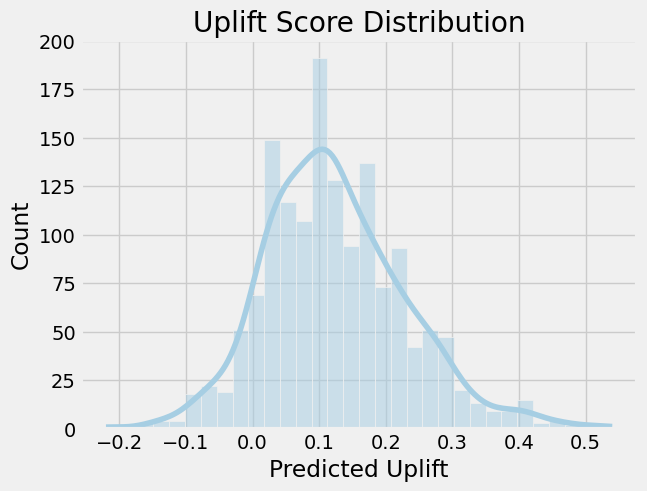

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize uplift distribution
sns.histplot(uplift_score_sklearn, kde=True)
plt.title('Uplift Score Distribution')
plt.xlabel('Predicted Uplift')
plt.show()

## Visualizing Uplift by Segment
or

Or group by a customer segment:

## Plot with Error Bars Using Seaborn

group by a customer segment:

/tmp/ipython-input-18-2082491987.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segment_uplift = df.groupby('customer_segment').apply(


Text(0.5, 1.0, 'Lift by Customer Segment')

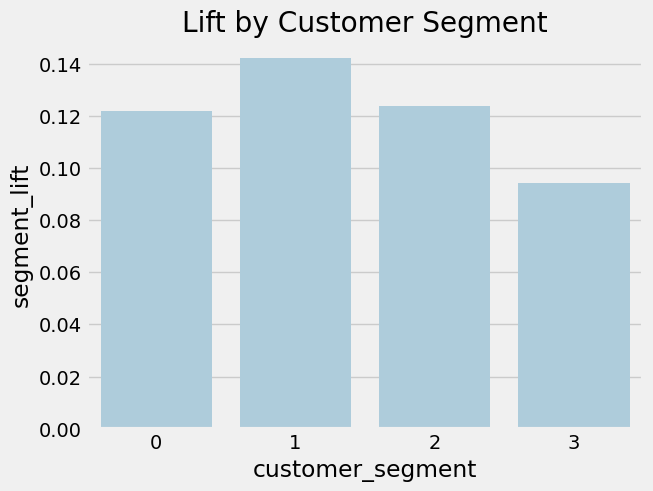

In [ ]:
segment_uplift = df.groupby('customer_segment').apply(
    lambda df: df[df['received_campaign']==1]['responded'].mean() -
               df[df['received_campaign']==0]['responded'].mean()
).reset_index(name='segment_lift')

sns.barplot(data=segment_uplift, x='customer_segment', y='segment_lift')
plt.title('Lift by Customer Segment')

## Interpretation

**Segment 1** has the highest uplift (~0.14):

* Customers in this segment responded 14 percentage points more when they received the campaign compared to when they didn’t.

* Ideal target for future campaigns.

**Segments 0 and 2 have** moderate lift (~0.12):

* The campaign was also effective for them.

* Consider continuing or refining targeting strategies here.

**Segment 3** has the lowest lift (~0.09):

* The campaign still had a positive effect, but not as strong.

* You might want to investigate why (e.g., smaller sample size, already high base response rate, saturation).

## Calculate Uplift and Standard Error per Segment

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem

# Function to compute lift and its standard error
def compute_segment_lift(group):
    treat = group[group['received_campaign'] == 1]['responded']
    control = group[group['received_campaign'] == 0]['responded']

    lift = treat.mean() - control.mean()

    # Standard error = sqrt(se_treat² + se_control²)
    se = np.sqrt(sem(treat, nan_policy='omit')**2 + sem(control, nan_policy='omit')**2)

    return pd.Series({'segment_lift': lift, 'se': se})

# Apply per segment
segment_stats = df.groupby('customer_segment').apply(compute_segment_lift).reset_index()

/tmp/ipython-input-19-2934190814.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segment_stats = df.groupby('customer_segment').apply(compute_segment_lift).reset_index()


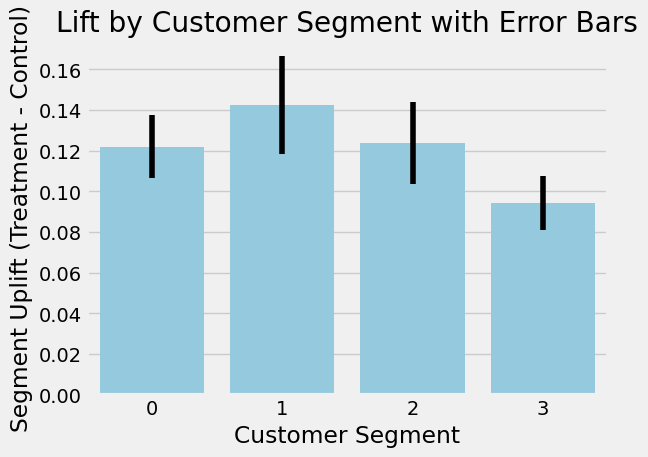

In [ ]:

sns.barplot(
    data=segment_stats,
    x='customer_segment',
    y='segment_lift',
    yerr=segment_stats['se'],       # error bars
    capsize=0.1,                    # small cap on error bars
    color='skyblue'
)

plt.title('Lift by Customer Segment with Error Bars')
plt.ylabel('Segment Uplift (Treatment - Control)')
plt.xlabel('Customer Segment')
plt.tight_layout()
plt.show()

- Overall campaign lift was 11.6%.
- Certain customer segments 1 showed higher positive response.
- Uplift modeling helps prioritize customers who are more likely to respond due to the campaign.

In [ ]:
# 10. Save Outputs

df.to_csv("/content/sample_data/campaign_data_with_uplift.csv", index=False)

## Next Step

Proceed to customer segmentation in `04_customer_segmentation.ipynb` to explore different customer clusters and improve targeting precision.
